In [ ]:
import torch
import numpy as np
import h5py
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader, Dataset

# Load the dataset
mat_file = h5py.File('nyu_depth_v2_labeled.mat', 'r')

# Extract RGB images and depth maps
rgb_images = np.array(mat_file['images'])  # Expected shape: (N, 3, H, W)
depth_maps = np.array(mat_file['depths'])   # Expected shape: (N, H, W)

# Normalize RGB images (from [0, 255] to [0, 1])
rgb_images = rgb_images.astype(np.float32) / 255.0

# Normalize depth maps (scale between 0 and 1)
depth_maps = depth_maps.astype(np.float32)
depth_maps /= np.max(depth_maps)  # Normalize depth values

# Convert to PyTorch tensors
# Note: We add the channel dimension here so each depth map becomes (1, H, W)
rgb_tensors = torch.tensor(rgb_images)
depth_tensors = torch.tensor(depth_maps).unsqueeze(1)  # Shape: (N, 1, H, W)

In [2]:
class NYUDepthDataset(Dataset):
    def __init__(self, rgb_data, depth_data):
        self.rgb_data = rgb_data
        self.depth_data = depth_data

    def __len__(self):
        return len(self.rgb_data)

    def __getitem__(self, idx):
        # Each item: (RGB image with shape (3, H, W), Depth map with shape (1, H, W))
        return self.rgb_data[idx], self.depth_data[idx]

# Create dataset and DataLoader (using a batch size of 16)
dataset = NYUDepthDataset(rgb_tensors, depth_tensors)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
# Set PyTorch to use all CPU threads
torch.set_num_threads(8)

class SimpleDepthCNN(nn.Module):
    def __init__(self):
        super(SimpleDepthCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Enable model compilation for faster execution (PyTorch 2.x)
model = SimpleDepthCNN()
if hasattr(torch, "compile"):
    model = torch.compile(model)

In [4]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import os
import psutil
import time

# Define K-Fold Cross Validation
k = 5  
num_epochs = 2  

batch_size = 16
num_workers = 4
snapshot_dir = "model_snapshots"
os.makedirs(snapshot_dir, exist_ok=True)  # Create snapshot directory if it doesn't exist

# Path to saved model
checkpoint_path = f"{snapshot_dir}/depth_model_kfold.pth"

# Load previous model if available
if os.path.exists(checkpoint_path):
    print(f"Loading model from {checkpoint_path}...")
    model.load_state_dict(torch.load(checkpoint_path))
else:
    print("No previous model found. Starting fresh.")

kf = KFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"\n--- Fold {fold+1}/{k} ---")

    # Create subsets and DataLoaders with multiprocessing
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for rgb_batch, depth_batch in train_loader:
            optimizer.zero_grad()

            # Reduce precision for faster computation
            rgb_batch, depth_batch = rgb_batch.to(dtype=torch.float16), depth_batch.to(dtype=torch.float16)

            output = model(rgb_batch)

            depth_batch_resized = F.interpolate(
                depth_batch, size=(output.shape[2], output.shape[3]),
                mode='bilinear', align_corners=False
            )

            loss = loss_function(output, depth_batch_resized)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # def limit_cpu_usage(max_usage=60):
            #     while psutil.cpu_percent(interval=1) > max_usage:
            #         print("CPU usage too high, pausing training...")
            #         time.sleep(1)

        # Save snapshot every epoch
        torch.save(model.state_dict(), f"{snapshot_dir}/depth_model_fold{fold+1}_epoch{epoch+1}.pth")
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.6f}")

    # Validation Phase
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for rgb_batch, depth_batch in val_loader:
            rgb_batch, depth_batch = rgb_batch.to(dtype=torch.float16), depth_batch.to(dtype=torch.float16)
            output = model(rgb_batch)

            depth_batch_resized = F.interpolate(
                depth_batch, size=(output.shape[2], output.shape[3]),
                mode='bilinear', align_corners=False
            )

            loss = loss_function(output, depth_batch_resized)
            val_loss += loss.item()

    print(f"Fold {fold+1} Validation Loss: {val_loss / len(val_loader):.6f}")

# Save final model
torch.save(model.state_dict(), checkpoint_path)
print("\nTraining complete. Model saved.")

Fold 1/5
Epoch 1/2, Train Loss: 0.030192262352737663
Epoch 2/2, Train Loss: 0.01959564462814429
Fold 1 Validation Loss: 0.02008783704552211

Fold 2/5
Epoch 1/2, Train Loss: 0.025997729997520577
Epoch 2/2, Train Loss: 0.019218739134910172
Fold 2 Validation Loss: 0.019589390605688095

Fold 3/5
Epoch 1/2, Train Loss: 0.024423765898873545
Epoch 2/2, Train Loss: 0.019585042477470553
Fold 3 Validation Loss: 0.018196689430624247

Fold 4/5
Epoch 1/2, Train Loss: 0.02613571615353839
Epoch 2/2, Train Loss: 0.019468946586528868
Fold 4 Validation Loss: 0.01853136424171297

Fold 5/5
Epoch 1/2, Train Loss: 0.029069444547369056
Epoch 2/2, Train Loss: 0.01880905672601641
Fold 5 Validation Loss: 0.019676230406682742



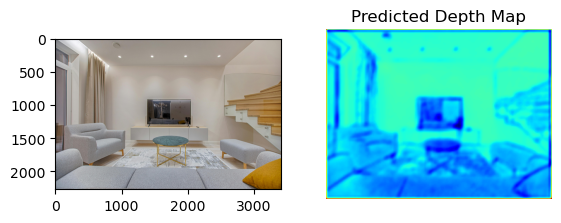

In [16]:
import cv2
import matplotlib.pyplot as plt

# Load a test RGB image
test_rgb = cv2.imread('test_image_2.jpg')
show_img = test_rgb.copy()
test_rgb = cv2.resize(test_rgb, (640, 480)) / 255.0  # Resize and normalize
test_rgb_tensor = torch.tensor(test_rgb).permute(2, 0, 1).unsqueeze(0).float()

# Predict depth
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predicted_depth = model(test_rgb_tensor).squeeze().numpy()

# Display predicted depth map
plt.subplot(1, 2, 1).imshow(cv2.cvtColor(show_img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2).imshow(predicted_depth, cmap='jet')
plt.title("Predicted Depth Map")
plt.axis("off")
plt.show()
